# Forecasting - Facebook Prophet
https://facebook.github.io/prophet/

https://research.fb.com/blog/2017/02/prophet-forecasting-at-scale/

https://peerj.com/preprints/3190.pdf

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 10)
pd.set_option('display.max_rows', 500)

import plotly.graph_objects as go

In [3]:

#attention might have problems with holiday package, 
#downgrate holidays via: pip install 'holidays==0.9.12'
from fbprophet import Prophet 

In [4]:
%matplotlib inline
plt.style.use('fivethirtyeight')

In [5]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Trivial Forecast (rolling mean)

In [6]:
# the final trivial model is at the end of this file

df = pd.DataFrame({'X': np.arange(0,10)}) # generate an input df
df['y']=df.rolling(3).mean() # take the window and write the average as the result

In [7]:
df

,X,y
0,0,NaN
1,1,NaN
2,2,1.0
3,3,2.0
4,4,3.0
5,5,4.0
6,6,5.0
7,7,6.0
8,8,7.0
9,9,8.0


# Small data set

In [9]:
df_all = pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')
df=df_all[['date','Germany']]
df=df.rename(columns={'date': 'ds',
                        'Germany': 'y'})

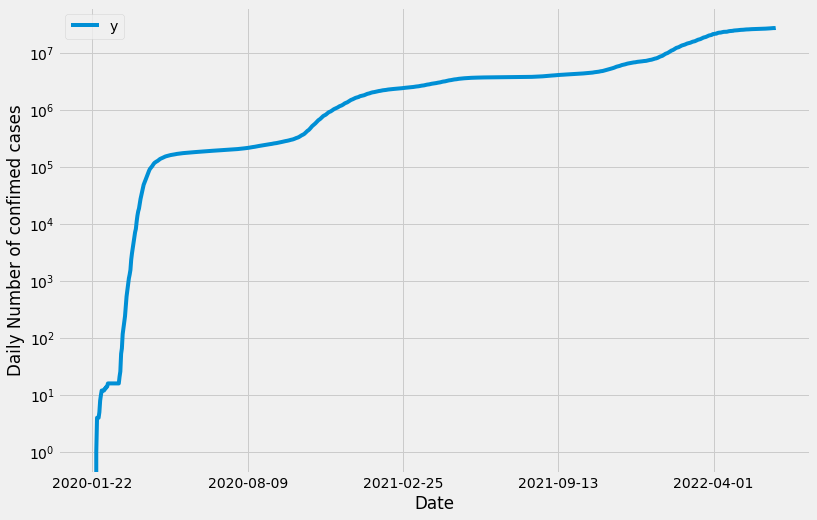

In [12]:
ax = df.set_index('ds').plot(figsize=(12, 8),
                             logy=True)
ax.set_ylabel('Daily Number of confimed cases')
ax.set_xlabel('Date')

plt.show()


In [13]:
# set the uncertainty interval to 95% (the Prophet default is 80%)

#my_model = Prophet(interval_width=0.95) # piecwise linear model
my_model = Prophet(growth='logistic')   # logistic model

In [ ]:
# the column 'cap' is only mandatory for the logistic model
df['cap']=1000000.
my_model.fit(df)


In [15]:
# define the periods and the frequency 'D'== days

future_dates = my_model.make_future_dataframe(periods=7, freq='D')
future_dates['cap']=1000000. # only mandatory for the logistic model
future_dates.tail()

,ds,cap
883,2022-06-23,1000000.0
884,2022-06-24,1000000.0
885,2022-06-25,1000000.0
886,2022-06-26,1000000.0
887,2022-06-27,1000000.0


In [16]:
# predict according to the scikit-learn standard

forecast = my_model.predict(future_dates)

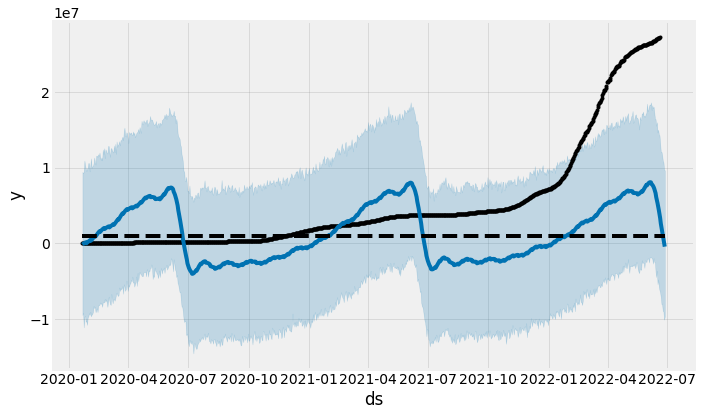

In [18]:
my_model.plot(forecast,
              uncertainty=True ); # since fbprohet is rendering the output

In [19]:
import plotly.offline as py
from fbprophet.plot import plot_plotly

fig = plot_plotly(my_model, forecast)  # This returns a plotly Figure

fig.update_layout(
    width=1024,
    height=900,
    xaxis_title="Time",
    yaxis_title="Confirmed infected people (source johns hopkins csse, log-scale)",
)
fig.update_yaxes(type="log",range=[1.1,5.5])
py.iplot(fig)

In [20]:
forecast.sort_values(by='ds').head()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,116112.480218,1000000.0,-9.499206e+06,9.453389e+06,116112.480218,116112.480218,-275846.693747,-275846.693747,-275846.693747,-58955.435580,-58955.435580,-58955.435580,-216891.258167,-216891.258167,-216891.258167,0.0,0.0,0.0,-159734.213529
1,2020-01-23,117188.725015,1000000.0,-9.201779e+06,9.290720e+06,117188.725015,117188.725015,-203421.904057,-203421.904057,-203421.904057,-20872.826713,-20872.826713,-20872.826713,-182549.077344,-182549.077344,-182549.077344,0.0,0.0,0.0,-86233.179042
2,2020-01-24,118273.610654,1000000.0,-1.112994e+07,9.472146e+06,118273.610654,118273.610654,-138244.527596,-138244.527596,-138244.527596,11772.639431,11772.639431,11772.639431,-150017.167027,-150017.167027,-150017.167027,0.0,0.0,0.0,-19970.916942
3,2020-01-25,119367.181726,1000000.0,-9.719914e+06,1.095990e+07,119367.181726,119367.181726,-80404.643961,-80404.643961,-80404.643961,38163.686598,38163.686598,38163.686598,-118568.330559,-118568.330559,-118568.330559,0.0,0.0,0.0,38962.537765
4,2020-01-26,120469.482583,1000000.0,-9.618996e+06,1.036414e+07,120469.482583,120469.482583,-33047.939740,-33047.939740,-33047.939740,54361.324023,54361.324023,54361.324023,-87409.263763,-87409.263763,-87409.263763,0.0,0.0,0.0,87421.542843


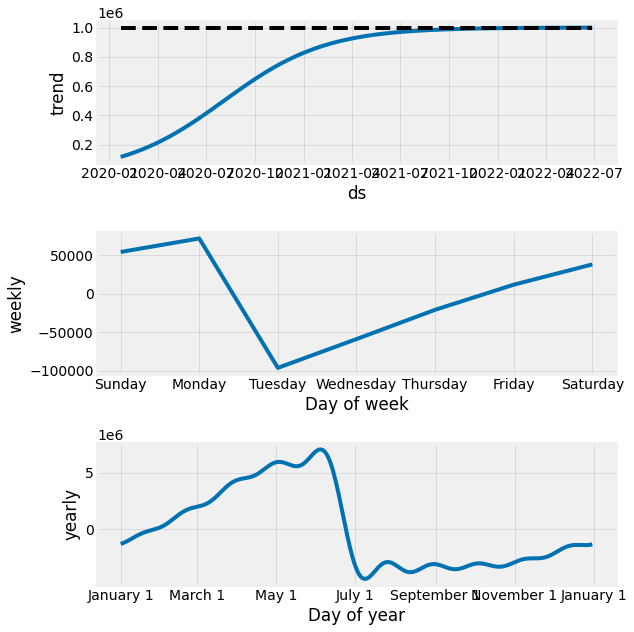

In [21]:
my_model.plot_components(forecast);

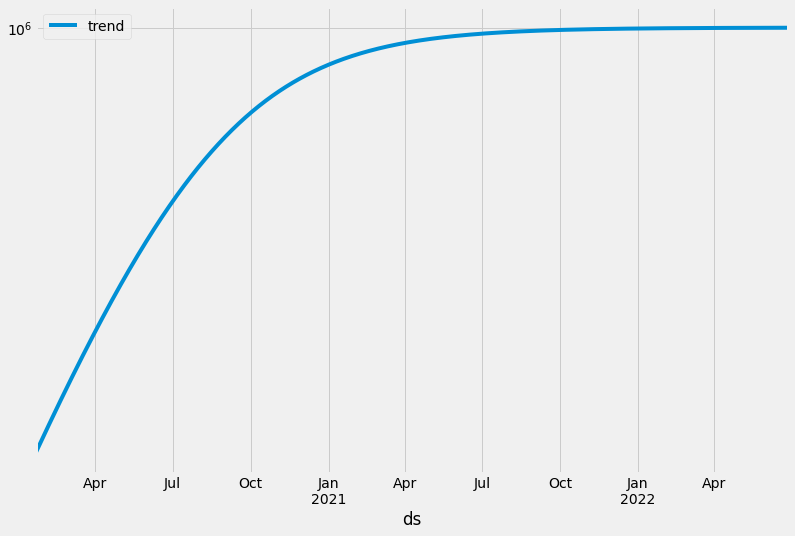

In [22]:
forecast[['ds','trend']].set_index('ds').plot(figsize=(12, 8),logy=True)

# Cross-Validation

In [23]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(my_model, 
                         initial='40 days', # we take the first 30 days for training
                         period='1 days',  # every  days a new prediction run
                         horizon = '7 days') #we predict 7days into the future

INFO:fbprophet:Making 834 forecasts with cutoffs between 2020-03-02 00:00:00 and 2022-06-13 00:00:00


  0%|          | 0/834 [00:00<?, ?it/s]

In [24]:
df_cv.sort_values(by=['cutoff','ds'])[0:12]
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-03-03,209.530586,206.808182,212.064494,188,2020-03-02
1,2020-03-04,278.729189,275.863916,281.643143,240,2020-03-02
2,2020-03-05,362.723397,358.923420,366.710525,349,2020-03-02
3,2020-03-06,466.401127,461.377448,471.345903,534,2020-03-02
4,2020-03-07,584.356704,577.523955,591.387132,684,2020-03-02


In [25]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)

In [26]:
# the performance matrix shows the result for all horizon
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,6.096529e+13,7.808027e+06,4.270111e+06,0.453895,0.539291,0.082734
1,2 days,6.442474e+13,8.026503e+06,4.408935e+06,0.472422,0.559854,0.044365
2,3 days,6.797408e+13,8.244640e+06,4.547970e+06,0.490589,0.580272,0.029976
3,4 days,7.158139e+13,8.460579e+06,4.686027e+06,0.509663,0.603593,0.020384
4,5 days,7.520406e+13,8.672027e+06,4.821802e+06,0.529056,0.625260,0.013189
5,6 days,7.880256e+13,8.877080e+06,4.954119e+06,0.547884,0.642579,0.008393
6,7 days,8.234352e+13,9.074333e+06,5.082011e+06,0.567003,0.660808,0.003597


/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:526: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.

/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:527: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.



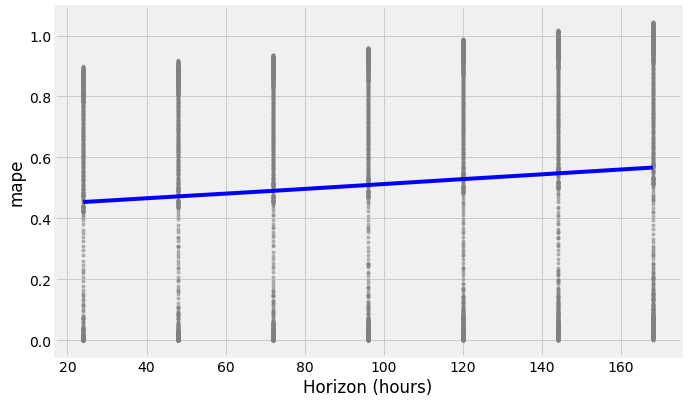

In [27]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape',)

# Diagonalplot 

### gives a good understanding for the under and over estimation w.r.t. magnitude 

In [28]:
horizon='7 days'
df_cv['horizon']=df_cv.ds-df_cv.cutoff

date_vec=df_cv[df_cv['horizon']==horizon]['ds']
y_hat=df_cv[df_cv['horizon']==horizon]['yhat']
y=df_cv[df_cv['horizon']==horizon]['y']

In [29]:
df_cv_7=df_cv[df_cv['horizon']==horizon]
df_cv_7.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,horizon
5809,2022-06-16,-132668.309660,-9.715541e+06,8.939252e+06,27124689,2022-06-09,7 days
5816,2022-06-17,-147466.850232,-9.774784e+06,8.858775e+06,27204953,2022-06-10,7 days
5823,2022-06-18,-185390.707384,-9.803889e+06,8.902995e+06,27204955,2022-06-11,7 days
5830,2022-06-19,-221927.636676,-9.055666e+06,9.925126e+06,27211896,2022-06-12,7 days
5837,2022-06-20,-272321.940563,-9.491876e+06,9.877956e+06,27334993,2022-06-13,7 days


In [30]:
type(df_cv['horizon'][0])

pandas._libs.tslibs.timedeltas.Timedelta

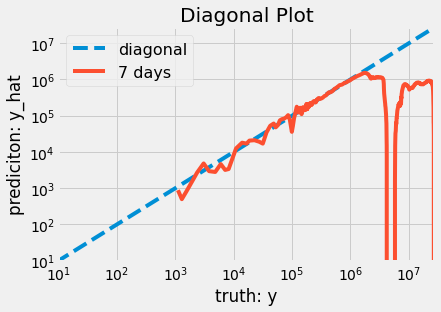

In [31]:
fig, ax = plt.subplots(1, 1)

ax.plot(np.arange(max(y)),np.arange(max(y)),'--',label='diagonal')
ax.plot(y,y_hat,'-',label=horizon)  # horizon is a np.timedelta objct

ax.set_title('Diagonal Plot')
ax.set_ylim(10, max(y))

ax.set_xlabel('truth: y')
ax.set_ylabel('prediciton: y_hat')
ax.set_yscale('log')

ax.set_xlim(10, max(y))
ax.set_xscale('log')
ax.legend(loc='best',
           prop={'size': 16});

# Trivial Forecast

 Example trivial forecast, prediciton 7 days into the future

In [32]:
def mean_absolute_percentage_error(y_true, y_pred): 
    ''' MAPE calculation '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [34]:
parse_dates=['date']
df_all = pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';',parse_dates=parse_dates)
df_trivial=df_all[['date','Germany']]
df_trivial=df_trivial.rename(columns={'date': 'ds',
                        'Germany': 'y'})

### One of the standard forecast is a rolling mean 

An other standard forecast is the exponentially-weighted moving average,
see pandas.ewma

In [35]:
df_trivial['y_mean_r3']=df_trivial.y.rolling(3).mean() # take the average of 3 days

In [36]:
# the result has to be shifted according to the prediciton horizon (here 7 days)

df_trivial['cutoff']=df_trivial['ds'].shift(7)
df_trivial['y_hat']=df_trivial['y_mean_r3'].shift(7)
df_trivial['horizon']=df_trivial['ds']-df_trivial['cutoff']
print('MAPE: '+str(mean_absolute_percentage_error(df_trivial['y_hat'].iloc[12:,], df_trivial['y'].iloc[12:,])))
df_trivial

MAPE: 36.734167455522815


,ds,y,y_mean_r3,cutoff,y_hat,horizon
0,2020-01-22,0,NaN,NaT,NaN,NaT
1,2020-01-23,0,NaN,NaT,NaN,NaT
2,2020-01-24,0,0.000000e+00,NaT,NaN,NaT
3,2020-01-25,0,0.000000e+00,NaT,NaN,NaT
4,2020-01-26,0,0.000000e+00,NaT,NaN,NaT
...,...,...,...,...,...,...
876,2022-06-16,27124689,2.707623e+07,2022-06-09,2.666073e+07,7 days
877,2022-06-17,27204953,2.714207e+07,2022-06-10,2.673435e+07,7 days
878,2022-06-18,27204955,2.717820e+07,2022-06-11,2.678209e+07,7 days
879,2022-06-19,27211896,2.720727e+07,2022-06-12,2.680566e+07,7 days
